In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os


def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import EnvironmentFactory
from dynamic_programming.opinion_dynamics.common.viz import (
    interpolate_opinion_trajectory,
    plot_action_heatmap,
    plot_opinions_over_time,
)
from dqn.opinion_dynamics.experiments.baseline import flatten_intermediate_states_np, run_policy_agent


def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file
    in the provided experiment subdirectory. The agent is created with the
    given training and validation environments and loads its previous state.

    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.


    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn"),
    )

    return agent




2025-07-13 23:04:52,912 - dqn - INFO - opinion_dqn.py:266 - Loaded configuration settings.
2025-07-13 23:04:52,914 - dqn - INFO - opinion_dqn.py:328 - Initialized networks and optimizer.
2025-07-13 23:04:54,738 - dqn - INFO - opinion_dqn.py:211 - Loaded previous training status from the following files: {'replay_buffer_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul12-011043_configs\\0001_agent_params.args_.target_model_update_freq_5000\\3\\opinion_agent_dqn_replay_buffer', 'train_stats_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul12-011043_configs\\0001_agent_params.args_.target_model_update_freq_5000\\3\\opinion_agent_dqn_train_stats', 'checkpoint_model_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul12-011043_configs\\0001_agent_params.args_.target_model_update_freq_5000\\3\\model_checkpoints\\mck_60'}
Simulation ended at step 20: done=True

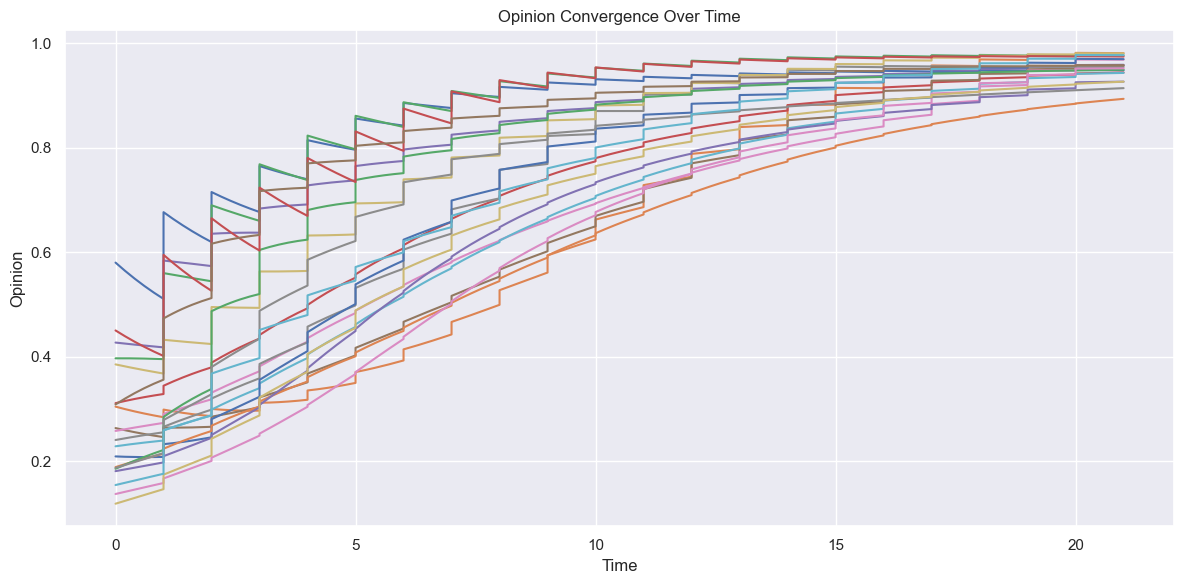

In [19]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May02-101004_configs\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\1" # excellent run

# was a decent run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May29-012929_configs\0000_optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.5__agent_params.args_.target_model_update_freq_1000\1"

# exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul09-171538_configs\0000_agent_params.args_.target_model_update_freq_5000__agent_params.args_.training_freq_4\2"

exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul12-011043_configs\0001_agent_params.args_.target_model_update_freq_5000\3"


agent = instantiate_agent(exp_subdir)

max_steps = 30
states, times, rewards, actions, all_intermediate_states = run_policy_agent(agent, max_steps=max_steps)


# If you also want to plot the fine-grained (t_s) trajectory:
flat_states, flat_times = flatten_intermediate_states_np(all_intermediate_states, 
                                                         agent.train_env.t_campaign, 
                                                         agent.train_env.t_s)
plot_opinions_over_time(flat_states, flat_times)

# # Plot the t_campaign-level trajectory (coarse)
# plot_opinions_over_time(states, times)

In [20]:
len(actions)

21

In [21]:
# TODO: beta = [0, 2]
# TODO: Try other validation envs
# TODO: start article draft

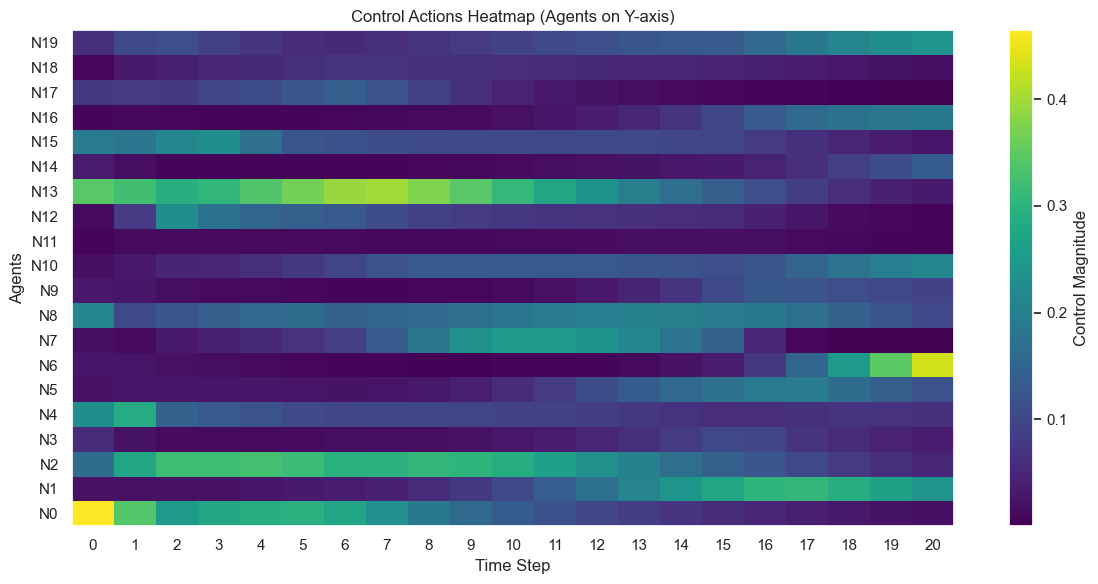

In [22]:
plot_action_heatmap(actions)

In [23]:
gamma = 0.99
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r

total_value

-6.189805631283391

In [24]:
# Add multiple budget levels
# Retrieve the budget levels used and plug into NAHS control

In [25]:
np.sum(actions, axis=1)

array([2.       , 2.0000002, 1.9999998, 1.9999998, 2.       , 1.9999999,
       2.0000002, 1.9999998, 2.       , 1.9999999, 2.0000002, 2.       ,
       2.       , 2.0000002, 1.9999998, 1.9999998, 2.       , 2.       ,
       2.       , 2.0000002, 1.9999999], dtype=float32)

In [26]:
sum(rewards)

-6.503855514574934

In [40]:
# array of 20 rand elements between 0 and 1
state = np.random.rand(20)
state_tensor = torch.tensor(state, dtype=torch.float32)
(u, beta_idx, w_full, max_q) = agent.select_action(state_tensor, epsilon=1, random_action=True)

print(beta_idx)
print(u.sum())

[1]
1.9999999
